In [77]:
import os
import scanpy as sc
import numpy as np
import torch
from torch_geometric.data import Data, Dataset
from scipy.sparse import csr_matrix
import rootutils
rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)
from src.data.spatial_omics_datamodule import SpatialOmicsDataModule
from src.models.bgrl_module import BGRLLitModule
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [78]:
datamodule = SpatialOmicsDataModule(
    data_dir="../data/domain/raw", 
    processed_dir="../data/domain/processed/",
    redo_preprocess=False
    )

datamodule.prepare_data()
datamodule.setup()
test_dataloder = datamodule.test_dataloader()

for batch in test_dataloder:
    print(batch.sample_name[0])
    print(batch.x.shape)

BaristaSeq1
torch.Size([1512, 50])
MERFISH_small1
torch.Size([5488, 50])
STARmap4
torch.Size([1088, 50])
STARmap2
torch.Size([1049, 50])
STARmap3
torch.Size([1053, 50])
MERFISH_small5
torch.Size([5543, 50])
MERFISH_small4
torch.Size([5803, 50])
STARmap1
torch.Size([1207, 50])
BaristaSeq3
torch.Size([1627, 50])
MERFISH_small3
torch.Size([5926, 50])
MERFISH_small2
torch.Size([5557, 50])
BaristaSeq2
torch.Size([2017, 50])


In [79]:
desired_sample_name = "MERFISH_small4"
batch = None

for b in test_dataloder:
    if b.sample_name[0] == desired_sample_name:
        batch = b
        break

print(batch)
print(batch.sample_name)

DataBatch(x=[5803, 50], edge_index=[2, 139722], edge_weight=[139722], sample_name=[1], batch=[5803], ptr=[2])
['MERFISH_small4']


In [80]:
checkpoint_path = "../logs/train_domain/runs/2025-03-31_15-41-12/checkpoints/epoch_011.ckpt"
model = BGRLLitModule.load_from_checkpoint(checkpoint_path).net.online_encoder
model

/Users/michel/miniconda3/envs/augmentation/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


TwoLayerGCN(
  (conv1): GCNConv(50, 32)
  (conv2): GCNConv(32, 16)
)

In [81]:
with torch.no_grad():
    node_embeddings = model(batch.x, batch.edge_index, batch.edge_weight)
node_embeddings.shape

torch.Size([5803, 16])

In [82]:
adata = sc.read_h5ad(os.path.join("../data/domain/processed/", desired_sample_name + ".h5ad"))
adata

AnnData object with n_obs × n_vars = 5803 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'domain_colors', 'log1p', 'pca'
    obsm: 'X_pca', 'adj', 'spatial'
    varm: 'PCs'

In [83]:
cell_embeddings_np = node_embeddings.cpu().numpy()
adata.obsm["cell_embeddings"] = cell_embeddings_np
adata

AnnData object with n_obs × n_vars = 5803 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'domain_colors', 'log1p', 'pca'
    obsm: 'X_pca', 'adj', 'spatial', 'cell_embeddings'
    varm: 'PCs'

In [84]:

sc.pp.neighbors(adata, use_rep="cell_embeddings")  # Build the neighborhood graph
sc.tl.leiden(adata, resolution=0.13)  # Perform Leiden clustering
print(adata.obs["leiden"])

Unnamed: 0
1148x-733    6
1150x-713    6
1154x-761    6
1162x-823    6
1174x-690    6
            ..
2858x325     0
2861x526     3
2913x728     6
2938x558     3
2753x918     6
Name: leiden, Length: 5803, dtype: category
Categories (8, object): ['0', '1', '2', '3', '4', '5', '6', '7']


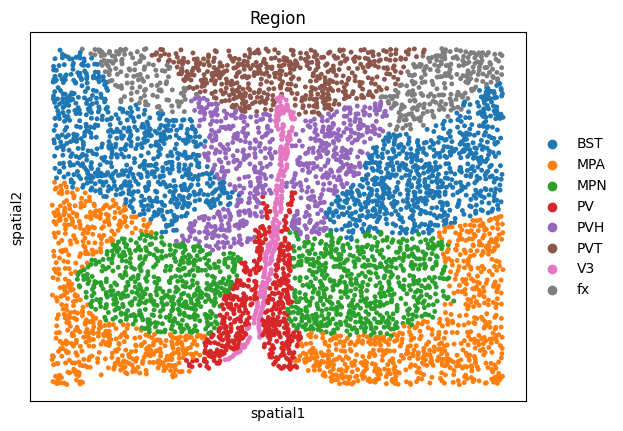

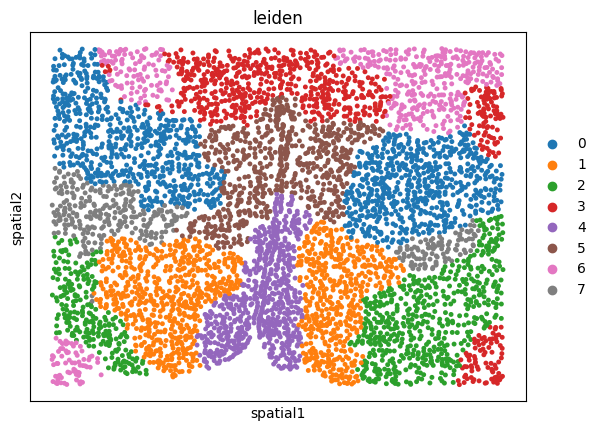

In [85]:
sc.pl.embedding(adata, basis="spatial", color="Region", size=50)
sc.pl.embedding(adata, basis="spatial", color="leiden", size=50)

In [86]:
# Ground truth labels
ground_truth_labels = adata.obs["Region"]

# Leiden clustering labels
leiden_labels = adata.obs["leiden"]

# Compute NMI
nmi = normalized_mutual_info_score(ground_truth_labels, leiden_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Compute ARI
ari = adjusted_rand_score(ground_truth_labels, leiden_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

Normalized Mutual Information (NMI): 0.5998
Adjusted Rand Index (ARI): 0.5353
